# Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import plotly.express as px
import pandas as pd
import json
import plotly.graph_objects as go
import pickle

# Block Time

In [3]:
# Source of data: https://aspm.faa.gov/apm/sys/AnalysisCP.asp
# For Detail information: https://aspm.faa.gov/aspmhelp/index/ASPM_City_Pair_Analysis__Definitions_of_Variables.html
# We choose departure as major five airports in Tennessee and arrivals are all the airports
df=pd.read_excel("/home/kamal/Desktop/IEEEBigData/Dataset/APM-Report-2022.xlsx")

In [4]:
unique_values = df['Arrival'].unique()

In [5]:
# Importing file containing all the  airports list
df_airports=pd.read_excel("/home/kamal/Desktop/IEEEBigData/Dataset/airport-codes.xlsx")

In [6]:
# Selecting the airports of US only
selected_rows = df_airports[df_airports['Country Abbrev.'] == 'US']

In [7]:
# Selecting all the airport code in an array
airport_codes = selected_rows['Airport Code'].values

In [8]:
df_final = df[df['Arrival'].isin(airport_codes)]

In [9]:
# We need onlly the actual block time
df_final=df_final[['Departure','Arrival','Average Actual Block Time']]

In [10]:
# Source of data: https://www.transtats.bts.gov/Distance.aspx
df=pd.read_csv("/home/kamal/Desktop/IEEEBigData/Dataset/Distance_of_All_Airports.csv")

In [11]:
filtered_df = df[(df['ORIGIN'] == 'BNA') & (df['DEST'].isin(['MEM', 'CHA', 'TYS', 'TRI']))]

In [12]:
# List of specific airport codes
airport_codes = ['BNA', 'MEM', 'CHA', 'TYS', 'TRI']

selected_airports = df[df['ORIGIN'].isin(airport_codes)]
selected_airports=selected_airports[['ORIGIN','DEST','DISTANCE IN MILES']]

In [13]:
selected_airports = selected_airports.rename(columns={
    'ORIGIN': 'Departure',
    'DEST': 'Arrival',
    # Add more columns as needed
})

In [14]:
# Merging the dataframes
result = pd.merge(df_final, selected_airports, on=['Departure', 'Arrival'], how='left')

In [15]:
# Remove rows where 'DISTANCE IN MILES' has NaN values
cleaned_df = result.dropna(subset=['DISTANCE IN MILES'])

In [16]:
df = cleaned_df[['Average Actual Block Time','DISTANCE IN MILES']]

In [17]:
# Filter the DataFrame to include only distances of 500 miles or less
filtered_df = df[(df['DISTANCE IN MILES'] > 10) & (df['DISTANCE IN MILES'] < 500) & (df['Average Actual Block Time'] < 400) ].copy()

filtered_df['Average Actual Block Time']= filtered_df['Average Actual Block Time']/60  # Changing time to hours

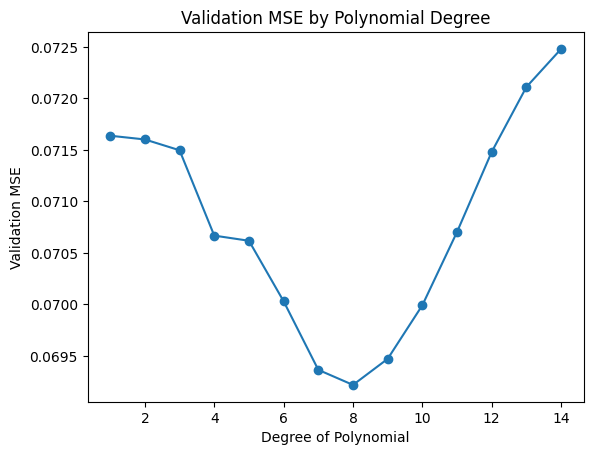

Best polynomial degree: 8


In [18]:
# Prepare data
X = filtered_df['DISTANCE IN MILES'].values.reshape(-1, 1)
y = filtered_df['Average Actual Block Time'].values



# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

# Test different degrees
degrees = range(1, 15)
validation_scores = []
models = []
for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = mean_squared_error(y_val, y_pred)
    validation_scores.append(score)
    models.append(model)

# Plot validation scores
plt.plot(degrees, validation_scores, marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Validation MSE')
plt.title('Validation MSE by Polynomial Degree')
plt.show()

# Choose the model with the lowest validation MSE
best_degree = degrees[np.argmin(validation_scores)]
best_model = models[np.argmin(validation_scores)]
print("Best polynomial degree:", best_degree)

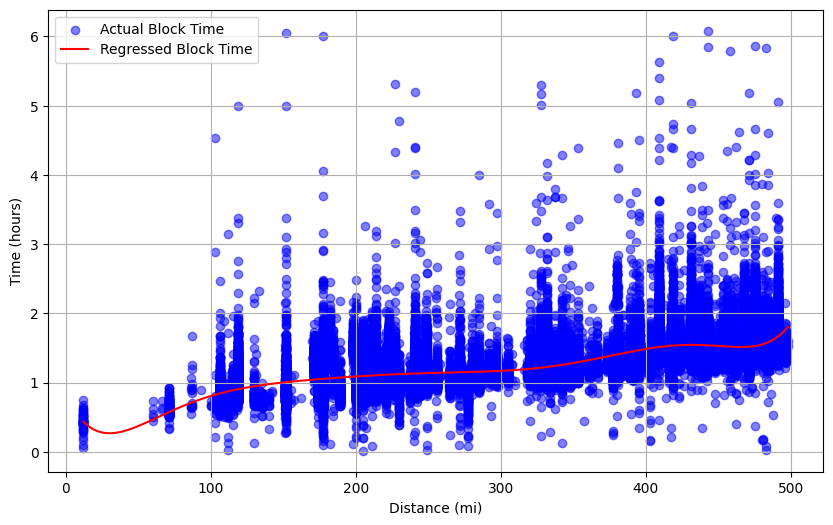

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_df['DISTANCE IN MILES'], filtered_df['Average Actual Block Time'], test_size=0.2, random_state=42)

# Fit a polynomial regression
degree = 8  # Degree can be adjusted based on how well you need the curve to fit
coefficients = np.polyfit(X_train, y_train, degree)
polynomial = np.poly1d(coefficients)

# Generate predicted y-values for training and testing sets
y_train_pred = polynomial(X_train)
y_test_pred = polynomial(X_test)

# Calculate and print the training and testing errors
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Generate predicted y-values using the polynomial for plotting
x_values = np.linspace(min(filtered_df['DISTANCE IN MILES']), max(filtered_df['DISTANCE IN MILES']), 400)
y_values = polynomial(x_values)

# Plotting the scatter plot and the regression curve
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['DISTANCE IN MILES'], filtered_df['Average Actual Block Time'], color='blue', alpha=0.5, label='Actual Block Time')
plt.plot(x_values, y_values, color='red', label='Regressed Block Time')
plt.xlabel('Distance (mi)')
plt.ylabel('Time (hours)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Save coefficients to a file
with open('/home/kamal/Desktop/IEEEBigData/SavedModel/polynomial_blockTime_coefficients.pkl', 'wb') as file:
    pickle.dump(coefficients, file)